In [1]:
import fbprophet
import geopandas as gpd
import fiona
import matplotlib.pyplot as plt
import contextily as ctx
import numpy as np
import pandas as pd
#load biodiversity data
biodiversity = gpd.read_file('biodiversity_species_2011_2019.csv')

biodiversity['Latitude (WGS84)'].replace('', np.nan, inplace=True)
biodiversity['Longitude (WGS84)'].replace('', np.nan, inplace=True)

gbiod = gpd.GeoDataFrame(
    biodiversity, geometry=gpd.points_from_xy(x=biodiversity['Longitude (WGS84)'].astype('float'),y=biodiversity['Latitude (WGS84)'].astype('float')))


gbiod.crs = "EPSG:4326"
gbiod = gbiod.to_crs(epsg=3857)
gbiod.head()

/Users/florencehope/opt/anaconda3/lib/python3.8/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


,Occurrence ID,Family,Genus,Common name,Class,OSGR,Start date,area_represented,OSGR 100km,OSGR 10km,OSGR 2km,OSGR 1km,Latitude (WGS84),Longitude (WGS84),geometry
0,1507997,Motacillidae,Anthus,Meadow Pipit,Aves,SK41G,,meadow,SK,SK41,SK41G,,52.712959,-1.364931,POINT (-151943.424 6930078.599)
1,MMEEECJAEEEHGLKR,Rosaceae,Fragaria,Wild Strawberry,Magnoliopsida,SN71,,meadow,SN,SN71,,,51.819602,-3.814957,POINT (-424679.071 6767572.678)
2,1242731,Alaudidae,Alauda,Skylark,Aves,SK40N,,meadow,SK,SK40,SK40N,,52.658863,-1.336146,POINT (-148739.092 6920144.420)
3,1507896,Alaudidae,Alauda,Skylark,Aves,SK41G,,meadow,SK,SK41,SK41G,,52.712959,-1.364931,POINT (-151943.424 6930078.599)
4,MMEEECJAEEE0SS3O,Motacillidae,Anthus,Meadow Pipit,Aves,SS79,,meadow,SS,SS79,,,51.63987,-3.80777,POINT (-423879.017 6735269.441)


In [4]:
import pandas as pd

gbiod['Start date'].replace('', np.nan, inplace=True)

gbiod = gbiod.dropna()
gbiod['dt'] = pd.to_datetime(gbiod['Start date'])
gbiod['dtm'] = gbiod['dt'].dt.normalize() - pd.offsets.MonthBegin(1)



In [5]:
# total area for the grid
import numpy as np 
import shapely

xmin, ymin, xmax, ymax = gbiod.total_bounds
# how many cells across and down

cell_size = 10000

# projection of the grid
#crs = "EPSG:27700"
crs = "EPSG:3857"

# create the cells in a loop

grid_cells = []

for x0 in np.arange(xmin, xmax+cell_size, cell_size ):
    for y0 in np.arange(ymin, ymax+cell_size, cell_size):
        # bounds
        half_step = cell_size/2
        x1 = x0-cell_size
        y1 = y0+cell_size
        grid_cells.append( shapely.geometry.box(x0 + half_step, y0 + half_step, x1 + half_step, y1 + half_step)  )


start_cell = gpd.GeoDataFrame(grid_cells, columns=['geometry'], 
                                 crs=crs)
start_cell


''' grid in biodiversitydata'''
cellbiod = start_cell

''' grid in biodiversitydata'''
cellbiod = start_cell

gridded_biod = gpd.sjoin(gbiod, cellbiod, how='left', op='intersects')


In [6]:
unique_species_types = gridded_biod.groupby(['index_right','dtm'])['Common name'].nunique()

df = pd.DataFrame(unique_species_types.transpose()).reset_index()
df = df.join(cellbiod, how='right',on='index_right')
gpdf = gpd.GeoDataFrame(df,geometry='geometry')



In [7]:
gpdf.head()

,index_right,dtm,Common name,geometry
NaN,0.0,NaT,NaN,"POLYGON ((-972941.517 2890355.375, -972941.517..."
NaN,1.0,NaT,NaN,"POLYGON ((-972941.517 2900355.375, -972941.517..."
NaN,2.0,NaT,NaN,"POLYGON ((-972941.517 2910355.375, -972941.517..."
NaN,3.0,NaT,NaN,"POLYGON ((-972941.517 2920355.375, -972941.517..."
NaN,4.0,NaT,NaN,"POLYGON ((-972941.517 2930355.375, -972941.517..."


<AxesSubplot:>

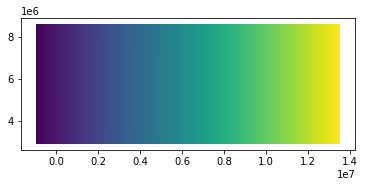

In [8]:
gpdf = gpd.GeoDataFrame(df,geometry='geometry')
gpdf['Common name'].replace('', np.nan, inplace=True)

gpdf.plot(column='index_right')

In [11]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from datetime import datetime

start_date = datetime(2018, 1, 1)
end_date = datetime(2020, 1, 1)

start_date = datetime(2018, 1, 1)
end_date = datetime(2019, 12, 1)

dates = pd.date_range(start_date, end_date, freq='MS')


options = [(date.strftime(' %d %b %Y '), date) for date in dates]


index = (0, len(options)-1)



selection_range_slider = widgets.SelectionRangeSlider(
    options=options,
    index=index,
    description='Dates',
    orientation='horizontal',
    layout={'width': '500px'}
)



def ukplot(date):
    #ax = gbiod[gbiod['dtm']==date[0]].plot(figsize=(14,14), legend = True,column='Common name',markersize=2)
    ax = gpdf[gpdf['dtm']==date[0]].plot(figsize=(14,14), vmax=12,legend = True,column='Common name',markersize=2)
    print(date)
    #ctx.add_basemap(ax)

widgets.interact(
    ukplot,
    date=selection_range_slider
)



interactive(children=(SelectionRangeSlider(description='Dates', index=(0, 23), layout=Layout(width='500px'), o…

<function __main__.ukplot(date)>